# Object Masking

## Load Datasets

In [4]:
import cv2
import datetime
import itertools as it
import matplotlib.pyplot as plt
import numpy as np
import random
import os

%matplotlib inline

In [5]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_COLOR)
        if img is not None:
            images.append(img)
    return images

In [6]:
images_path = '../data/datasets/vegetable_dog_dataset/images'
images = load_images_from_folder(images_path)
sample_size = 4
sequential = True
plot_dpi = 144

images_count = len(images)
if sequential:
    start = random.randint(0, images_count - sample_size)
    taken_images_index = [*range(start, start + sample_size)]
else:
    taken_images_index = random.sample(range(images_count), sample_size if images_count > sample_size else images_count)
print('Taken {} from {} images'.format(taken_images_index, images_count))

sample_images = [images[i] for i in taken_images_index]
gray_images = []

for i in taken_images_index:
    gray_image = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
    gray_images.append(gray_image)

gray_image_index_pairs = [e for e in it.permutations(np.arange(len(gray_images)), 2)]
print('Gray image pairs: {}'.format(gray_image_index_pairs))

Taken [11, 12, 13, 14] from 25 images
Gray image pairs: [(0, 1), (0, 2), (0, 3), (1, 0), (1, 2), (1, 3), (2, 0), (2, 1), (2, 3), (3, 0), (3, 1), (3, 2)]


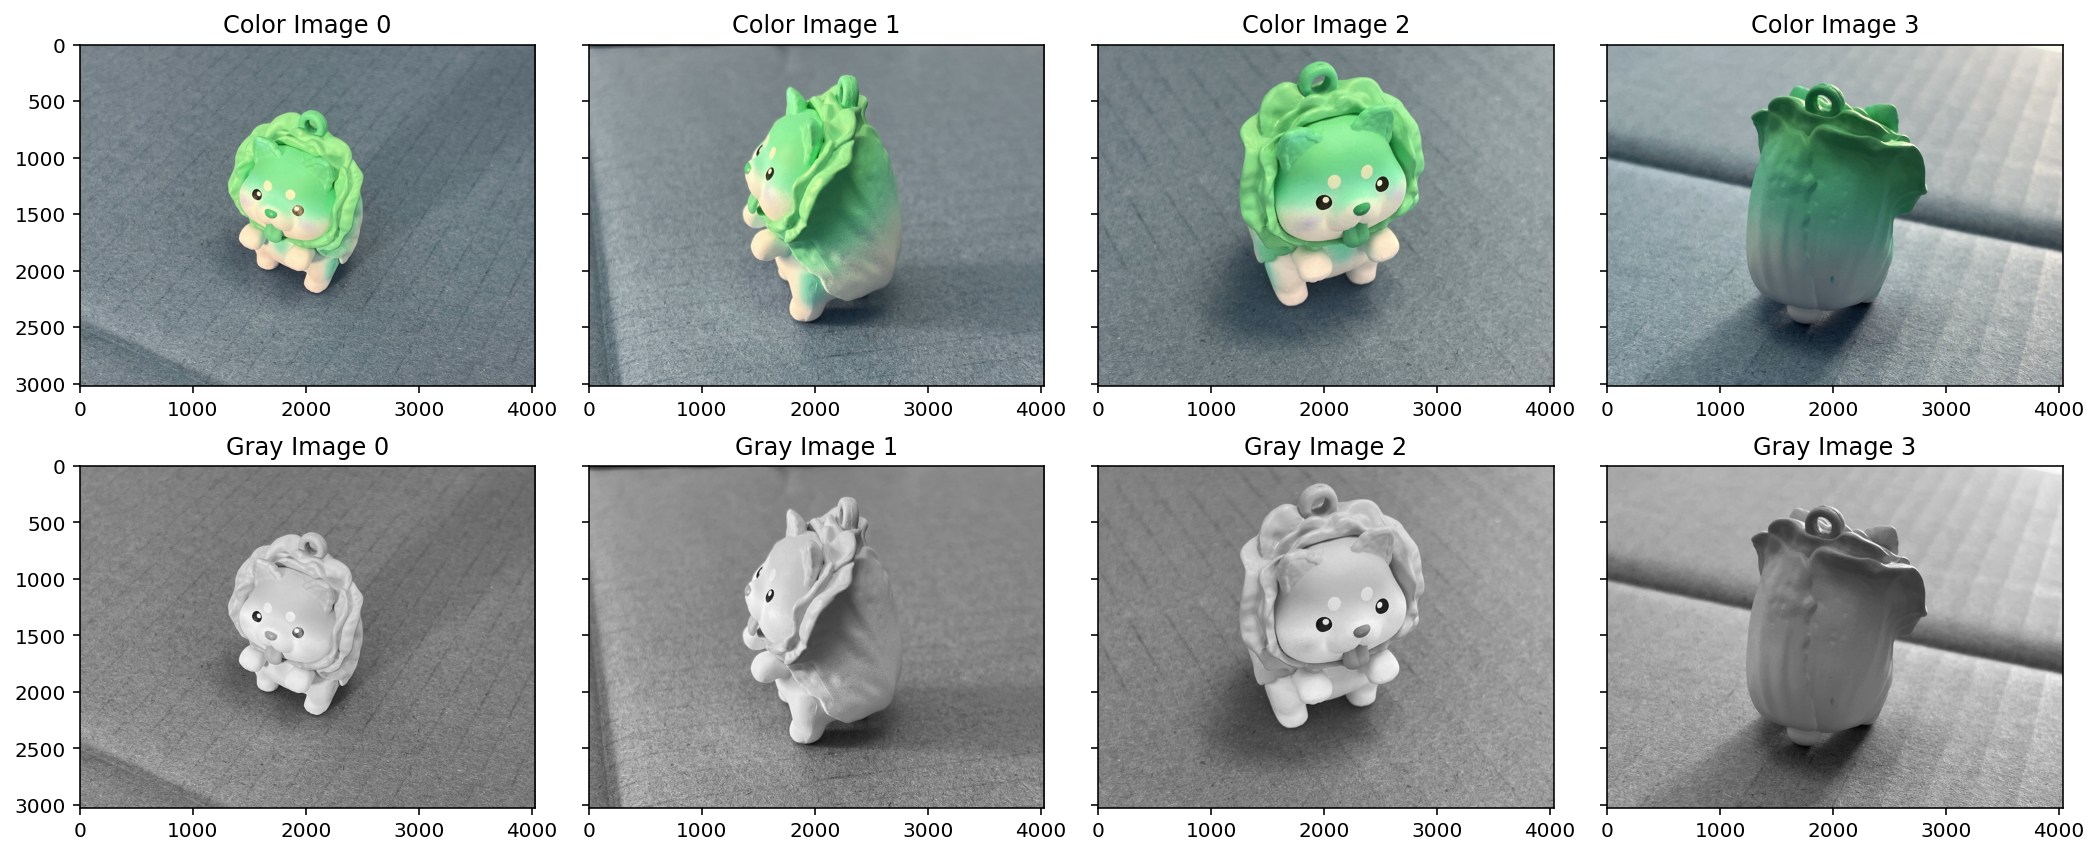

In [7]:
def display_samples(images):
    fig, ax = plt.subplots(2, len(images), figsize=(14.5, 6), constrained_layout=True, sharey=True)
    fig.set_dpi(plot_dpi)
    fig.tight_layout()

    for i in range(len(images)):
        ax[0, i].set_title('Color Image {}'.format(i))
        ax[0, i].imshow(images[i])
        ax[1, i].set_title('Gray Image {}'.format(i))
        ax[1, i].imshow(gray_images[i], cmap='gray')

display_samples(sample_images)

## Extract Objects by Masks

### DIS

In [17]:
import torch
from torchvision import transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Running inference on device \'{}\''.format(device))

Running inference on device "cpu"


In [38]:
from thirdparty.DIS.IS_Net.data_loader_cache import normalize, im_reader, im_preprocess 
from thirdparty.DIS.IS_Net.models.isnet import ISNetGTEncoder, ISNetDIS

hypar = {
    'model_path': '../data/models/is-net',  # load trained weights from this path
    'restore_model': 'isnet.pth',           # name of the to-be-loaded weights
    'interm_sup': False,                    # indicate if activate intermediate feature supervision
    'model_digit': 'full',                  # indicates 'half' or 'full' accuracy of float number
    'seed': 0,
    'cache_size': [1024, 1024],             # cached input spatial resolution, can be configured into different size
    'input_size': [1024, 1024],             # mdoel input spatial size, usually use the same value hypar['cache_size'], which means we don't further resize the images
    'crop_size': [1024, 1024],              # random crop size from the input, it is usually set as smaller than hypar['cache_size'], e.g., [920,920] for data augmentation
    'model': ISNetDIS()
}                                           # paramters for inferencing

In [48]:
# Normalize the Image using torch.transforms
class GOSNormalize(object):
    def __init__(self, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        self.mean = mean
        self.std = std

    def __call__(self, image):
        image = normalize(image, self.mean, self.std)
        return image

transform = transforms.Compose([GOSNormalize([0.5, 0.5, 0.5], [1.0, 1.0, 1.0])])

def normalize_2_tensor_with_size(im, hypar):
    im, im_shp = im_preprocess(im, hypar['cache_size'])
    im = torch.divide(im, 255.0)
    shape = torch.from_numpy(np.array(im_shp))
    return transform(im).unsqueeze(0), shape.unsqueeze(0) 

image_tensor_with_size = [normalize_2_tensor_with_size(im, hypar) for im in sample_images]

/Users/unbinilium/Documents/Develop/Python/SfM/lib/python3.10/site-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [46]:
def build_model(hypar, device):
    net = hypar['model'] #GOSNETINC(3, 1)

    # convert to half precision
    if(hypar['model_digit'] == 'half'):
        net.half()
        for layer in net.modules():
            if isinstance(layer, torch.nn.BatchNorm2d):
                layer.float()

    net.to(device)

    if(hypar['restore_model'] != ''):
        net.load_state_dict(torch.load(hypar['model_path'] + '/' + hypar['restore_model'], map_location=device))
        net.to(device)

    net.eval() 
     
    return net

dis_net = build_model(hypar, device)

In [47]:
# Given an Image, predict the mask
def predict(net, inputs_val, shapes_val, hypar, device):
    if(hypar['model_digit'] == 'full'):
        inputs_val = inputs_val.type(torch.FloatTensor)
    else:
        inputs_val = inputs_val.type(torch.HalfTensor)

    inputs_val_v = torch.autograd.Variable(inputs_val, requires_grad=False).to(device) # wrap inputs in Variable
   
    ds_val = net(inputs_val_v)[0] # list of 6 results

    pred_val = ds_val[0][0, :, :, :] # B x 1 x H x W, we want the first one which is the most accurate prediction

    # recover the prediction spatial size to the orignal image size
    pred_val = torch.squeeze(
        torch.nn.functional.upsample(torch.unsqueeze(pred_val, 0), (shapes_val[0][0], shapes_val[0][1]), mode='bilinear')
    )

    ma = torch.max(pred_val)
    mi = torch.min(pred_val)
    pred_val = (pred_val - mi) / (ma - mi) # max = 1

    return (pred_val.detach().cpu().numpy() * 255).astype(np.uint8) # it is the mask we need

In [49]:
image_tensor, orig_size = image_tensor_with_size[0]
mask = predict(dis_net, image_tensor, orig_size, hypar, device)

/Users/unbinilium/Documents/Develop/Python/SfM/lib/python3.10/site-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/Users/unbinilium/Documents/Develop/Python/SfM/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


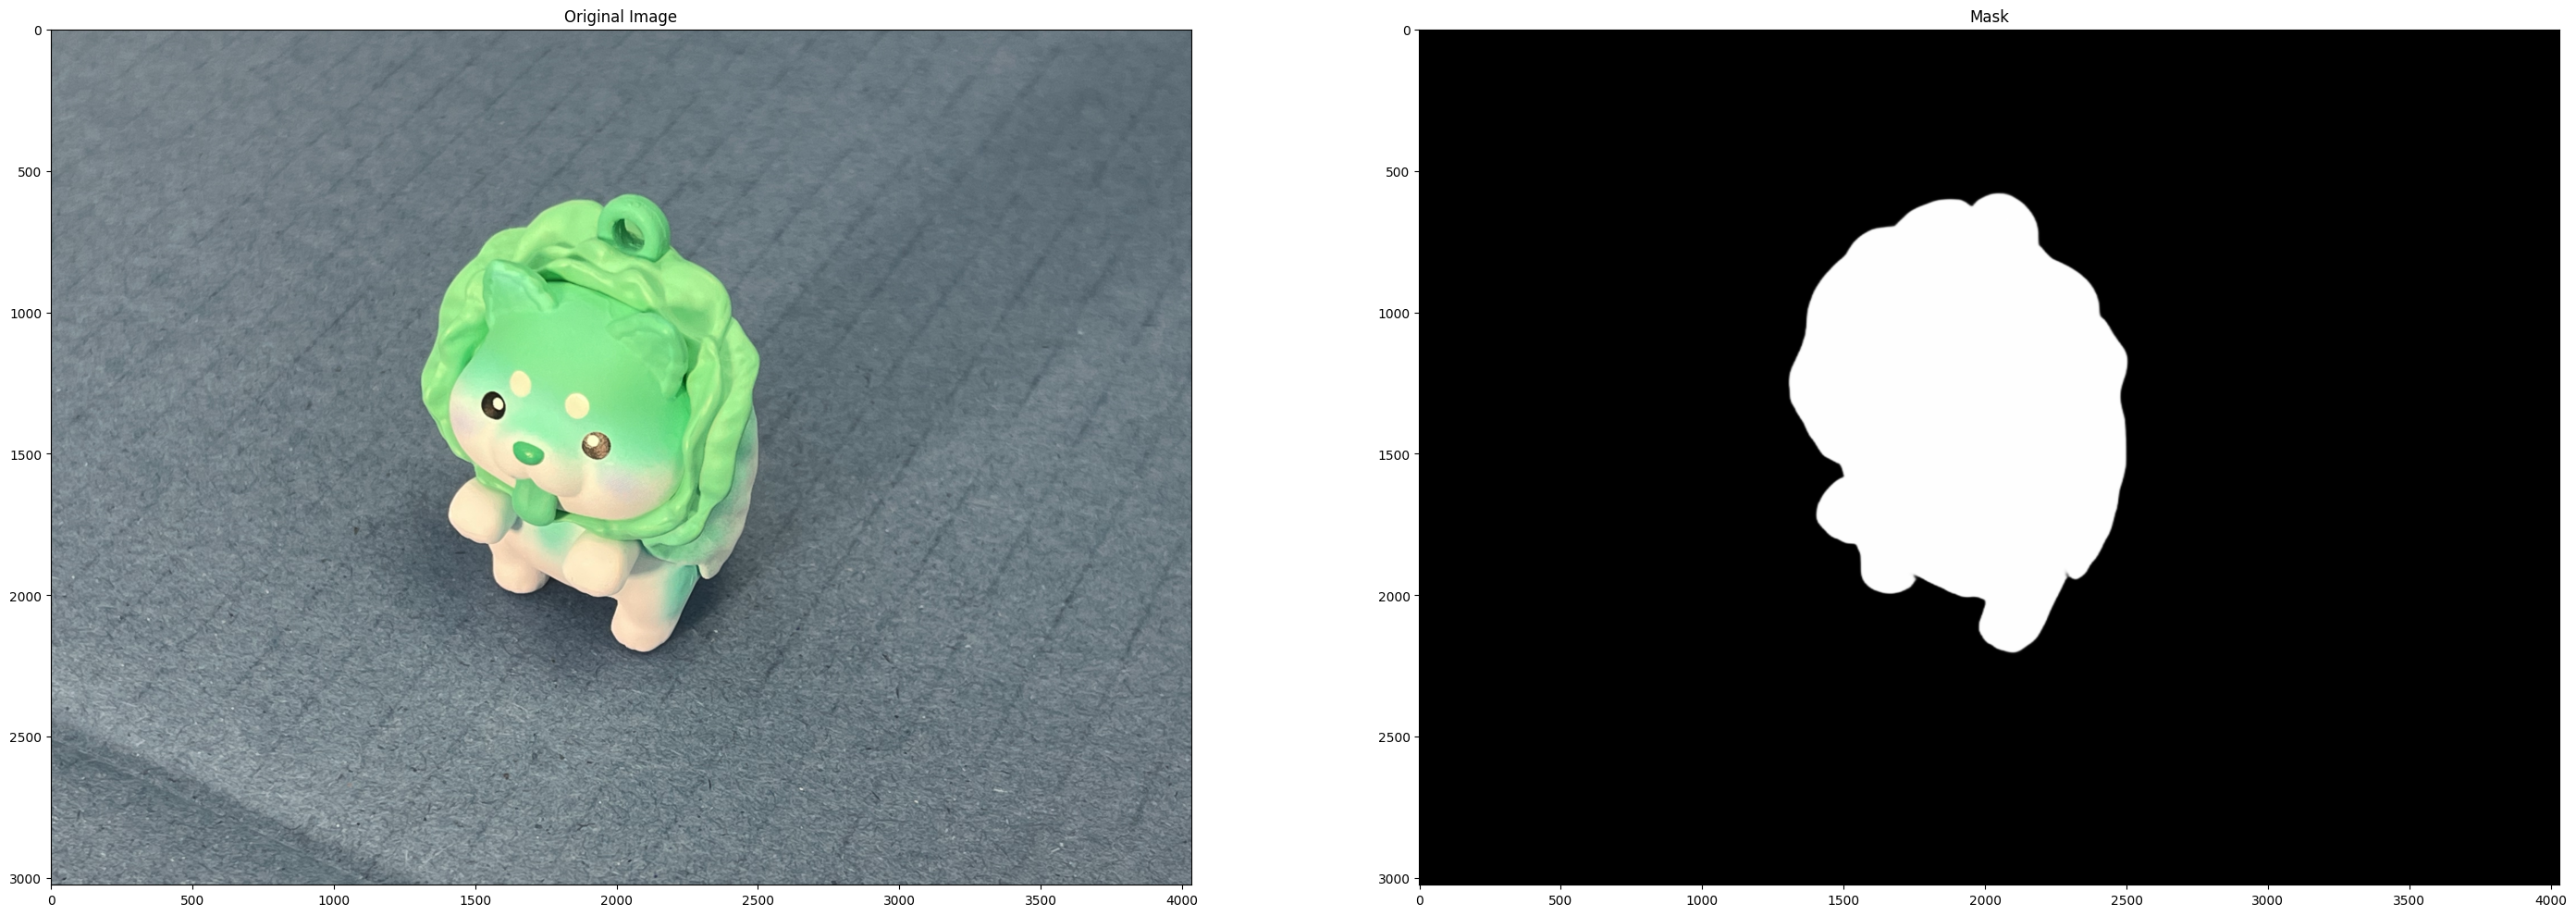

In [50]:
f, ax = plt.subplots(1,2, figsize = (35,20))

ax[0].imshow(sample_images[0])    # Original image
ax[1].imshow(mask, cmap = 'gray') # Retouched image

ax[0].set_title("Original Image")
ax[1].set_title("Mask")

plt.show()

### DeeplabV3

In [8]:
import ssl
import torch

ssl._create_default_https_context = ssl._create_unverified_context

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Running inference on device \'{}\''.format(device))

Running inference on device "cpu"


In [9]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', pretrained=True)
model.eval()

Using cache found in /Users/unbinilium/.cache/torch/hub/pytorch_vision_v0.10.0


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 

In [10]:
input_image = sample_images[0]

In [11]:
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image).to(device)
input_batch = input_tensor.unsqueeze(0)

In [12]:
output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

In [13]:
input_image.shape

(3024, 4032, 3)

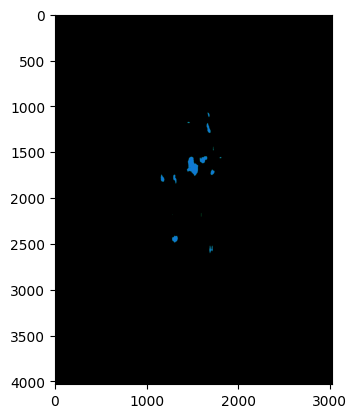

In [14]:
from PIL import Image

# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype('uint8')

# plot the semantic segmentation predictions of 21 classes in each color
result = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.shape[:2])
result.putpalette(colors)

import matplotlib.pyplot as plt
plt.imshow(result)
